# Image Captioning With Deep Learning

### Importing the essential libraries:

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

Using TensorFlow backend.


In [4]:
# использую следующий датасет https://www.kaggle.com/datasets/adityajn105/flickr8k
image_path = "Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

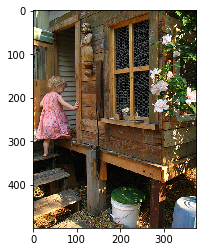

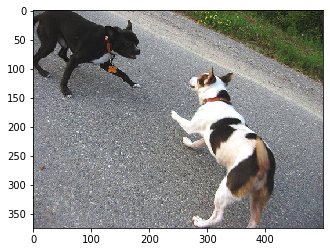

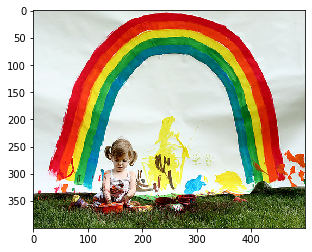

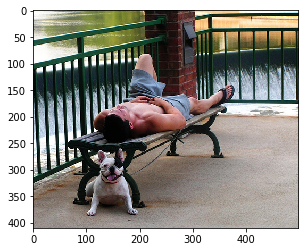

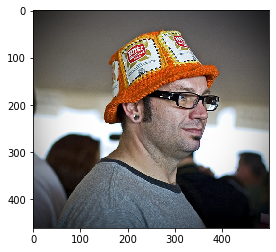

In [5]:
# визуализируем данные 
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

### Предобработка подписей данных

In [6]:
# Загружаем изначальные данные 

def load(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

file = "captions.txt"
info = load(file)
print(info[:484])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [7]:
# в изначальном файле удаляем первую и последнюю строчку, чтобы считать данные

file = "captions1.txt"
info = load(file)
print(info[:470])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting



In [8]:
# считываем информацию

count = 0

for line in info.split('\n'):
    print(line)
    count += 1
    if count == 5:
        break

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [9]:
# функция для создания словаря из подписей

def load_captions(info):
    dict_1 = dict()
    count = 0
    for line in info.split('\n'):
        
        splitter = line.split('.jpg,')
        # присваиваем отадельно переменным код картинки и подпись к ней
        image_code, image_caption = splitter[0], splitter[1]
        
        # создаем словарь
        if image_code not in dict_1:
            dict_1[image_code] = list()
            
        dict_1[image_code].append(image_caption)
        
    return dict_1

data = load_captions(info)
print(len(data))

8091


In [10]:
list(data.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [11]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# Очистим и предобработаем данные

def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()
            
            dict_2[key].append(lines)
            
    return dict_2

data2 = cleanse_data(data)
print(len(data2))           

8091


In [13]:
list(data2.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [14]:
data2['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way ',
 'girl going into wooden building ',
 'little girl climbing into wooden playhouse ',
 'little girl climbing the stairs to her playhouse ',
 'little girl in pink dress going into wooden cabin ']

In [15]:
# конвертировать предложение в словарь слов и посчитать колицество слов

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# суммируем словарный запас
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


In [16]:
# сохраним описание в файл

def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

In [17]:
images = 'Images/'
img = glob(images + '*.jpg')
print(len(img))

8091


In [18]:
def preprocess(image_path):
    # преобразуем изображения в размер 299, 299
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # преобразуем изображения PIL в трехмерный массив numpy
    x = keras.preprocessing.image.img_to_array(img)
    # добавим еще одно измерение
    x = np.expand_dims(x, axis=0)
    # предварительно обработаем изображения с помощью preprocess_input() из начального модуля
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

In [19]:
# загрузим модель v3
input1 = InceptionV3(weights='imagenet')

# удалем входной слой
model = Model(input1.input, input1.layers[-2].output)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
# функция для кодировани изображения в вектор размера (2048, )
def encode(image):
    image = preprocess(image) # предобработка изображения
    fea_vec = model.predict(image) # получение энкодированного вектора изображения
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # изменения (1, 2048) в (2048, )
    return fea_vec

In [22]:
encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [27:16<00:00,  4.94it/s]


In [23]:
import pickle

with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

In [24]:
# создаем список всех тренировочных заголовков

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

40455

In [25]:
# учитываем только слова, встречающиеся не менее 10 раз.

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 9149 -> 1975


In [26]:
# преобразуем слов в индексы и наоборот.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 
vocab_size

1976

In [27]:
with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)

In [28]:
# преобразуем словарь очищенных описаний в список описаний

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# рассчитываем длину описания с наибольшим количеством слов
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# определяем максимальную длину последовательности
max_length = max_length(data2)
print('Description Length: %d' % max_length)

Description Length: 33


In [29]:
# генератор данных, предназначенный для использования в вызове model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # цикл по всем изображениям
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # закодируем последовательность
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # разделим одну последовательность на несколько пар X, y
                for i in range(1, len(seq)):
                    # разделим на входную и выходную пару
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # кодируем выходную последовательность
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # сохраняем
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [30]:
embeddings_index = {} # пустой словарь
f = open('glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [31]:
embedding_dim = 200

# получаем 200-мерный плотный вектор для каждого из 10000 слов словаря.
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #если  i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #слова, не найденные в индексе внедрения, обнуляются
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(1976, 200)

In [32]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      395200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [34]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
epochs = 10
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

In [37]:
features = pickle.load(open("images1.pkl", "rb"))

In [38]:
tf.config.run_functions_eagerly(True)

In [39]:
for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

C:\Users\Admin\anaconda3\envs\tensors\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


2697/2697 [==============================] - 987s 365ms/step - loss: 2.7409


In [40]:
model.save_weights('./model_weights/final_model.h5')